In [ ]:
#load the required libraries
import json
import os
import PIL.Image
import google.generativeai as genai
from dotenv import load_dotenv

In [3]:
#load the API key from the .env file
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

In [4]:

img = PIL.Image.open("img\\Ashok_aadhaar.jpeg")

def extract_data(img):
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(
        [
            '''You are an expert in text extraction and formatting.
        Given the following image, return structured data with these fields:
        
        - Name
        - Date of Birth (format: DD-MM-YYYY)
        - Phone Number (10-digit format)
        - Aadhaar Number (12-digit format)
        - Gender (MALE/FEMALE/OTHER)
        - PAN Number (10-character alphanumeric)
        - VID Number (16-digit format)
        - Address


        If any field is missing, try to infer it or return "Not Found".
        ''',
            img,
        ],
        stream=True,
    )
    response.resolve()
    return response.text
try:
    extracted_data_str = extract_data(img)
    if not extracted_data_str:
        raise ValueError("Error: No text extracted from image.")
except Exception as e:
    print(f"❌ Extraction Failed: {e}")
# print("Extracted Data String:", extracted_data_str)

In [5]:
import re

def parse_extracted_text(extracted_text):
    """
    Parses the extracted text and converts it into a structured dictionary.
    """
    extracted_text = re.sub(r'\*+', '', extracted_text)
    
    fields = {
        "Name": r"Name:\s*([A-Za-z\s]+)",  # Only alphabets and spaces
        "Date of Birth": r"Date of Birth:\s*(\d{2}-\d{2}-\d{4})",
        "Phone Number": r"Phone Number:\s*(\d{10})",
        # Allows spaces
        "Aadhaar Number": r"Aadhaar Number:\s*(\d{4}\s?\d{4}\s?\d{4})",
        "Gender": r"Gender:\s*(MALE|FEMALE|OTHER)",
        # PAN format strict
        "PAN Number": r"PAN Number:\s*([A-Z]{5}[0-9]{4}[A-Z])",
        "VID Number": r"VID Number:\s*(\d{16})",
        "Address": r"Address:\s*([\w\s,.-]+)"  # Allows commas, dots, hyphens
    }
    
    extracted_data = {}
    
    for key, pattern in fields.items():
        match = re.search(pattern, extracted_text)
        extracted_data[key] = match.group(1).strip().upper() if match else "N/A"
    
    return extracted_data

structured_data = parse_extracted_text(extracted_data_str)
print("Extracted Data Dictionary:", structured_data)

Extracted Data Dictionary: {'Name': 'MALYALA LAKSHMINARAYANA ASHOK', 'Date of Birth': '16-06-2004', 'Phone Number': '9182756177', 'Aadhaar Number': '596261924261', 'Gender': 'MALE', 'PAN Number': 'N/A', 'VID Number': '9136018909390715', 'Address': 'NOT FOUND\n\n\nNOTE'}


In [6]:
import pdf2image
import pytesseract
from PIL import Image

def extract_text_from_pdf_images(pdf_path):
    images = pdf2image.convert_from_path(pdf_path)
    for page_num, image in enumerate(images):
        text = pytesseract.image_to_string(image)
        # print(f"Page {page_num + 1} OCR Text:\n", text)

# Example Usage
extract_text_from_pdf_images("img\\sbi_bank_form.pdf")

In [7]:
import pdf2image
import pytesseract
import cv2
import numpy as np
import re

def find_multiple_word_positions(pdf_path, search_words):
    images = pdf2image.convert_from_path(pdf_path)
    word_positions = {word.lower(): [] for word in search_words}  # Initialize dictionary

    for page_num, image in enumerate(images):
        img_cv = np.array(image)
        img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


        # Perform OCR with bounding box detection
        data = pytesseract.image_to_data(img_gray, output_type=pytesseract.Output.DICT)

        # Clean text data
        cleaned_text = [re.sub(r'[0-9:]', '', word) for word in data["text"]]
        data["text"] = cleaned_text

        # Call the function to merge multi-line fields
        merged_data = merge_multiline_fields(data)

        print(f"Page {page_num + 1} OCR Data:\n", merged_data["text"])

        for i, word in enumerate(merged_data["text"]):
            word_lower = word.lower().strip()
            # word_lower = re.sub(r'\W+', '', word.lower().strip())           # Remove non-alphanumeric characters
            if word_lower in word_positions:  # Check if word is in the search list
                x, y, w, h = merged_data["left"][i], merged_data["top"][i], merged_data["width"][i], merged_data["height"][i]
                # Store page number & coordinates
                word_positions[word_lower].append((page_num + 1, x, y, w, h))

    return word_positions

# Function to merge multi-line fields
def merge_multiline_fields(data, threshold_x=70, threshold_y=18):
    merged_fields = {
        "text": [],
        "left": [],
        "top": [],
        "width": [],
        "height": []
    }
    temp_field = ""
    last_x, last_y = 0, 0
    temp_left, temp_top, temp_width, temp_height = 0, 0, 0, 0

    for i, word in enumerate(data["text"]):
        if word:
            x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]

            if temp_field:  # If there's already a word in progress
                if abs(y - last_y) < threshold_y and abs(x - (last_x + temp_width)) < threshold_x:
                    temp_field += " " + word  # Merge words horizontally
                    temp_width = x + w - temp_left  # Update width to include new word
                    temp_height = max(temp_height, h)  # Update height to the maximum height
                else:
                    merged_fields["text"].append(temp_field)
                    merged_fields["left"].append(temp_left)
                    merged_fields["top"].append(temp_top)
                    merged_fields["width"].append(temp_width)
                    merged_fields["height"].append(temp_height)
                    temp_field = word  # Start new phrase
                    temp_left, temp_top, temp_width, temp_height = x, y, w, h
            else:
                temp_field = word  # Initialize first word
                temp_left, temp_top, temp_width, temp_height = x, y, w, h

            last_x, last_y = x, y  # Update position reference

    if temp_field:
        merged_fields["text"].append(temp_field)
        merged_fields["left"].append(temp_left)
        merged_fields["top"].append(temp_top)
        merged_fields["width"].append(temp_width)
        merged_fields["height"].append(temp_height)

    return merged_fields

# Example Usage
pdf_path = "img\\sbi_bank_form.pdf"
search_words = [".name*", ".date of birth*", ".gender*", "address*", ".pan*", "mobile no."]  # List of words to find
positions = find_multiple_word_positions(pdf_path, search_words)

# Print detected positions
for word, pos_list in positions.items():
    print(f"Positions for '{word}':", pos_list)

Page 1 OCR Data:
 ['Accessibility', 'Eu)', 'er', 'Sd', 'ACCOUNT OPENING', 'FORM FOR', 'RESIDENT INDIVIDUAL', '(PART -I)', 'Shan', '(Must be accompanied', 'with Terms and', 'Conditions)', 'Peed', 'CUSTOMER INFORMATION', 'SHEET (CIF', 'Creation/Amendment)', 'eS)', ' ', ' ', '(In case of Joint', 'Accounts /', 'Related Person /', 'Guardian, Part', '-I (CIF Sheet) and', 'Terms & Conditions', 'to be taken for', 'each customer) Date', 'In case of current account,', 'declaration cum', 'undertaking, to', 'be obtained', '       ', '       ', ' ', ' ', ' ', 'Branch Name', 'Branch Code', ' ', ' ', ' ', 'Fields marked asterisk', '(*) are mandatory. Please', 'fill up in BLOCK letters', 'only and use black', 'ink for signature', 'Bank/Branch to', 'affix rubber stamp', 'of', '(For office use', 'only}', 'name and code', 'no.', ' ', ' ', 'CustomerID', 'Application Type New', 'Update', ' ', '       ', ' ', ' ', ' ', ' ', ' ', 'Account No.', 'CKYC No.', '       ', '       ', '       ', ' ', ' ', '(Mandato

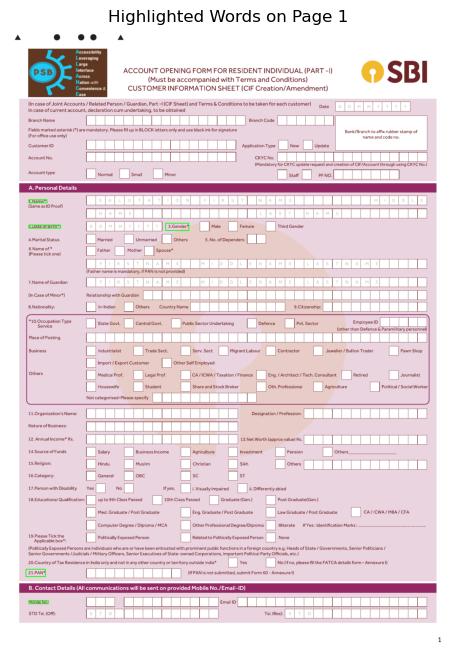

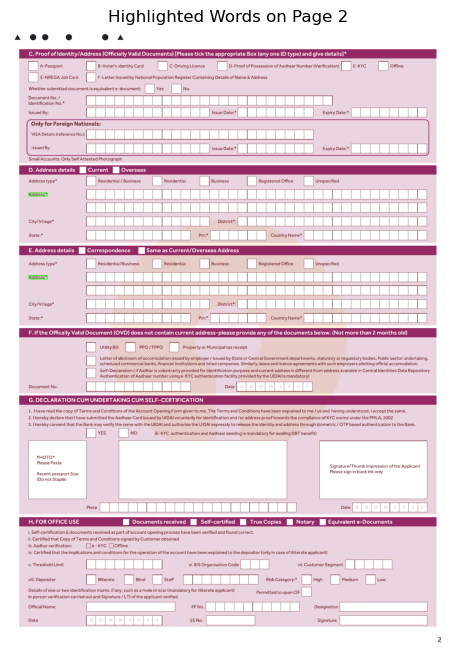

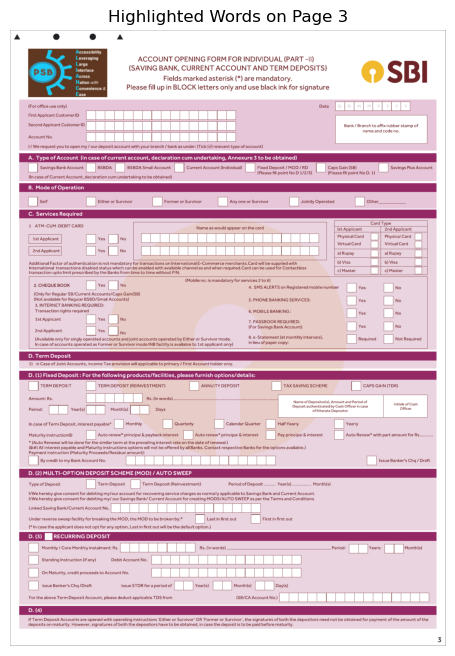

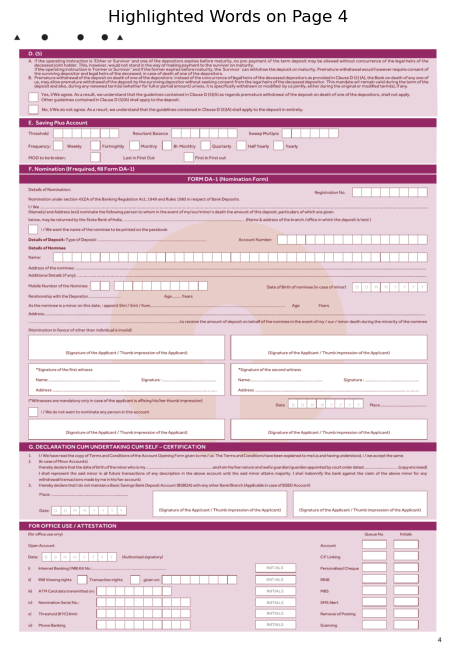

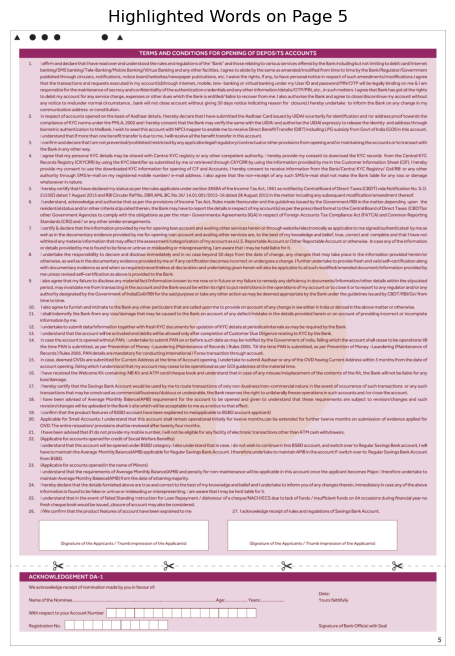

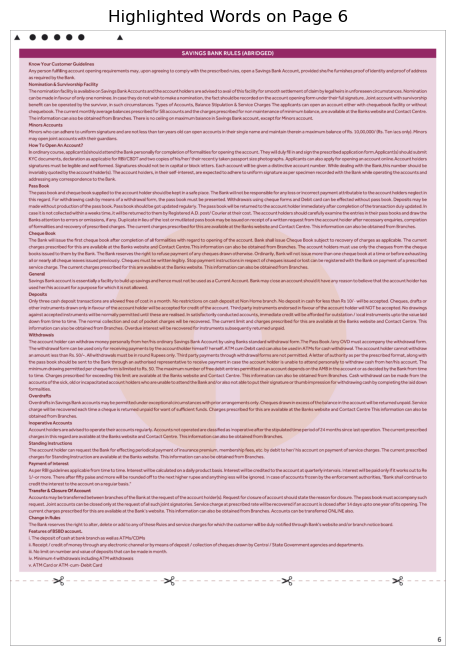

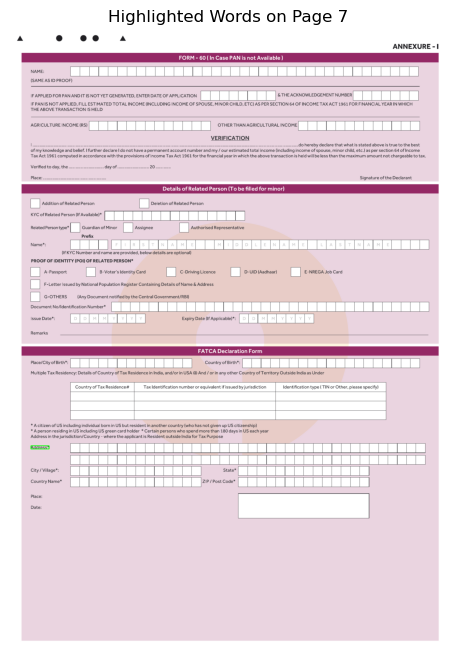

In [8]:
import matplotlib.pyplot as plt

def highlight_detected_words(pdf_path, search_words):
    images = pdf2image.convert_from_path(pdf_path)
    
    for page_num, image in enumerate(images):
        img_cv = np.array(image)
        img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        data = pytesseract.image_to_data(
            img_gray, output_type=pytesseract.Output.DICT)
        cleaned_text = [re.sub(r'[0-9:]', '', word) for word in data["text"]]
        data["text"] = cleaned_text
        merged_data = merge_multiline_fields(data)


        for i, word in enumerate(merged_data["text"]):
            word_lower = word.lower().strip()
            if word_lower in [w.lower() for w in search_words]:
                x, y, w, h = merged_data["left"][i], merged_data["top"][i], merged_data["width"][i], merged_data["height"][i]
                cv2.rectangle(img_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        plt.title(f"Highlighted Words on Page {page_num + 1}")
        plt.axis("off")
        plt.show()

# Example Usage
highlight_detected_words(pdf_path, search_words)

In [9]:
import sys
sys.path.append('C:\\Users\\Harsha\\AppData\\Roaming\\Python\\Python312\\site-packages')
import cv2
import pdf2image
import numpy as np
from PIL import ImageDraw, ImageFont
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO


def fill_form_with_extracted_data(pdf_path, extracted_data, word_positions, output_pdf_path):
    images = pdf2image.convert_from_path(pdf_path)  # Convert PDF to images
    font_path = "arialbd.ttf"  # Replace with the path to your TrueType font file
    font_size = 30
    font = ImageFont.truetype(font_path, font_size)

    mapping = {
        ".Name*": "Name",
        ".Date of Birth*": "Date of Birth",
        ".PAN*": "PAN Number",
        ".Gender*": "Gender",
        "aadhaar*": "Aadhaar Number",
        "Address*": "Address",
        "Mobile No.": "Phone Number"
    }

    for page_num, image in enumerate(images):
        img_cv = np.array(image)
        img_pil = image.copy()
        draw = ImageDraw.Draw(img_pil)
        
        for word, pos_list in word_positions.items():
            extracted_key = next((mapping[key] for key in mapping.keys() if key.lower() in word.lower()), None)
            
            if extracted_key and extracted_data.get(extracted_key) and extracted_data[extracted_key] != "NOT FOUND":
                value_to_fill = extracted_data[extracted_key]
                
                for (page, x, y, w, h) in pos_list:
                    if page == page_num + 1:
                        x_offset = x + 250
                        for letter in value_to_fill:
                            draw.text((x_offset, y - 10), letter, fill="Blue", font=font)
                            x_offset += font.getbbox(letter)[2] + 10  # Add space between letters
        
        images[page_num] = img_pil  # Update image
    
    images[0].save(output_pdf_path, save_all=True, append_images=images[1:])


# Example Usage
pdf_path = "img\\sbi_bank_form.pdf"
output_pdf_path = "output_filled_form.pdf"
fill_form_with_extracted_data(pdf_path, structured_data, positions, output_pdf_path)

print(f"Filled form saved to {output_pdf_path}")


Filled form saved to output_filled_form.pdf
